# ДЗ

1. Реализовать метрики: Precision@k, Recall@k, mAP
2. Добавить train - аугментации
3. Попробовать обучить другой backbone
4. Добавить triplet-loss (не забыть сэмплирование в батч)
5. Показать с помощью град Кама где ошибается модель

ФИО: Мушенко Егор Сергеевич

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
device = 'cuda'

In [2]:
import os
if not os.path.isfile('car_devkit.tgz'):
    #Грузим датасаты с авто 
    !wget "https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz"
    !tar -xzf car_devkit.tgz
if not os.path.isfile('cars_train.tgz'):
    !wget "http://ai.stanford.edu/~jkrause/car196/cars_train.tgz"
    !tar -xzf cars_train.tgz
if not os.path.isfile('cars_test.tgz'):
    !wget "http://ai.stanford.edu/~jkrause/car196/cars_test.tgz"
    !tar -xzf cars_test.tgz

--2023-04-26 12:50:34--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   270KB/s    in 1.2s    

2023-04-26 12:50:36 (270 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]

--2023-04-26 12:50:38--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  18.0MB/s    in 56s     

2023-04-26 12:51:34 (16.7 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]

--2023-0

In [3]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [4]:
ADD_PATH = './cars_train'

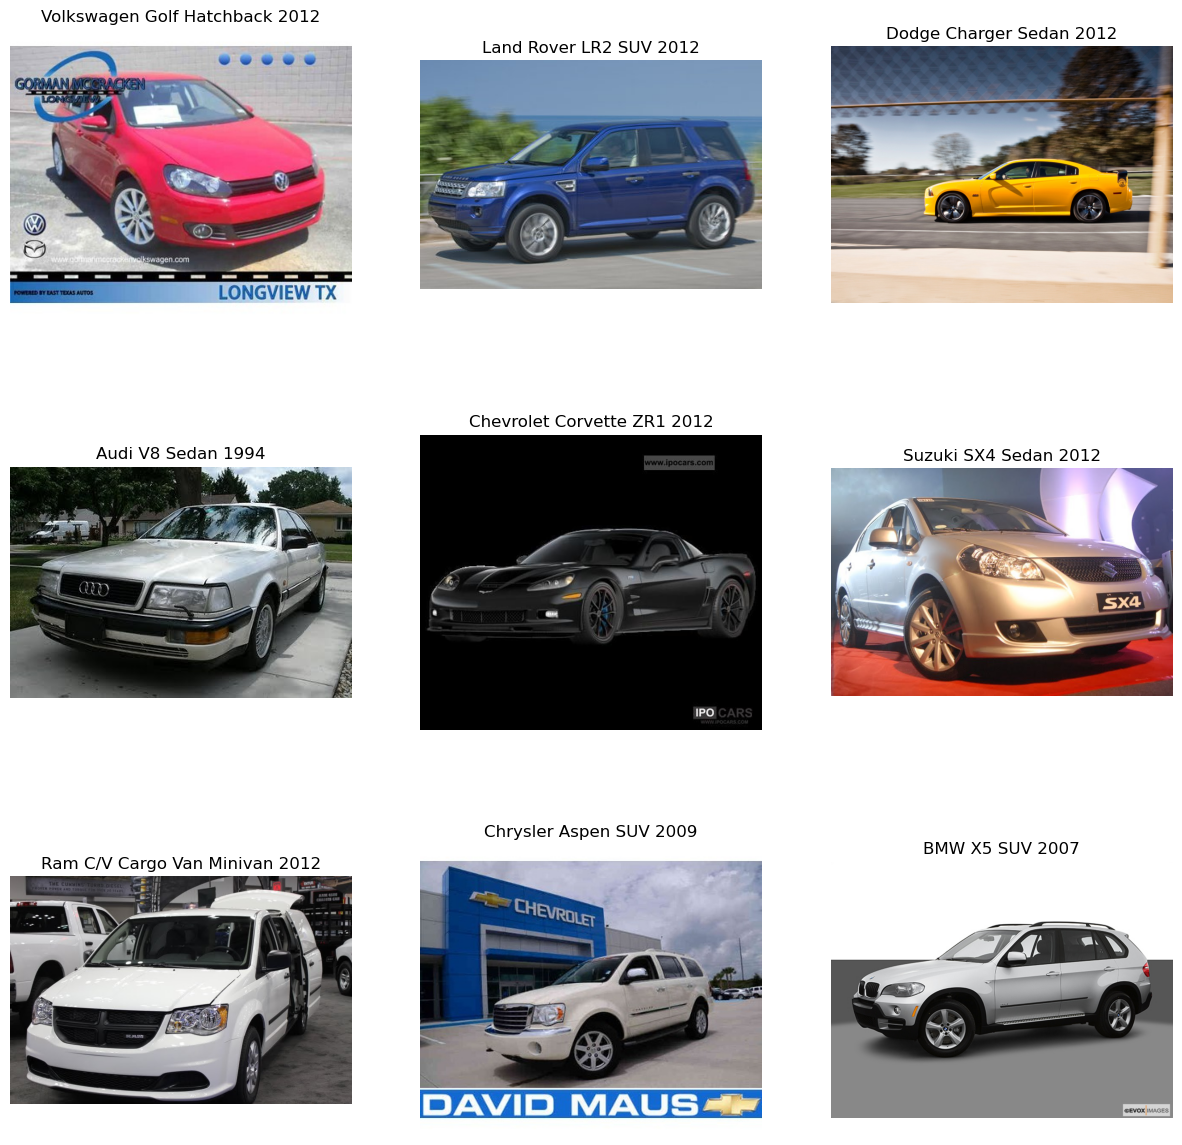

In [5]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

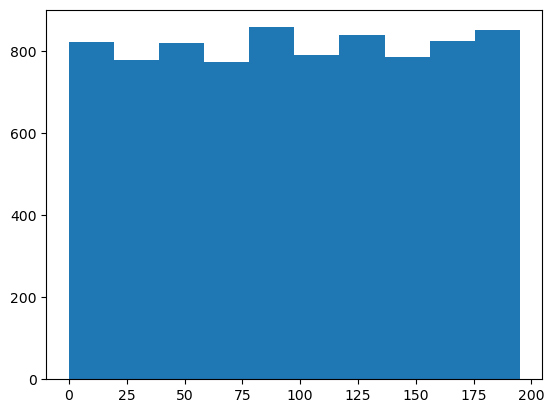

In [6]:
plt.hist(fname_to_class.values())
plt.show()

In [7]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random

train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ColorJitter(brightness=1, contrast=1, saturation=1, hue=0.3),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            torchvision.transforms.RandomInvert(),
            torchvision.transforms.RandomAutocontrast(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

val_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        labels = []
        for i in range(len(self.cars)):
            labels.append(self.cars[i][1])
        self.labels = np.array(labels)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        pos_items = np.where(self.labels == cl_id)[0]
        if idx in pos_items:
            pos_items = np.delete(pos_items, np.where(pos_items == idx)[0])
        pos_one_item = random.choice(pos_items)
        pos_filename, pos_cl_id = self.cars[pos_one_item]
        pos_image = cv2.imread(os.path.join(ADD_PATH, pos_filename))
        pos_img = cv2.cvtColor(pos_image, cv2.COLOR_BGR2RGB)
            
        neg_items = np.where(self.labels != cl_id)[0]
        if idx in neg_items:
            neg_items = np.delete(neg_items, np.where(pos_items == idx)[0])
        neg_one_item = random.choice(neg_items)
        neg_filename, neg_cl_id = self.cars[neg_one_item]
        neg_image = cv2.imread(os.path.join(ADD_PATH, neg_filename))
        neg_img = cv2.cvtColor(neg_image, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            image = self.transforms(image)
            pos_img = self.transforms(pos_img)
            neg_img = self.transforms(neg_img)
            
        sample = {'image': image, 'label': cl_id, 'positive': pos_img, 'negative': neg_img}
        return sample

In [8]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]

In [9]:
train_dataset = CropClassifDataset(train_items, train_transforms)

In [10]:
test_check = train_dataset[3]

In [11]:
val_items = items[int(len(items) * 0.8):]
val_dataset = CropClassifDataset(val_items, val_transforms)

In [12]:
# Другие функции
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, pin_memory=True)

In [13]:
import torch
import torch.nn as nn
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [14]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-zkcqqlb0
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-zkcqqlb0
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit d48ec08d76ec090fb0836b5da7f8f9d136f85426
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 31.7 MB/s eta 0:00:00
ERROR: Package 'lightning' requires a different Python: 3.7.12 not in '>=3.8'


In [15]:
!pip install ../input/installs/tensorboard-2.2.0-py3-none-any.whl -qqq
!pip install ../input/installs/pytorch_lightning-0.9.0-py3-none-any.whl -qqq

In [16]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision.models import resnet101

class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = resnet101(pretrained=True)
        
        self.model.fc = torch.nn.Sequential(
                            torch.nn.Linear(in_features=2048, out_features=emb_size))
        self.classifier_head = torch.nn.Sequential(
                            torch.nn.Linear(in_features=emb_size, out_features=len(class_dict)),
                            torch.nn.ReLU())
        self.classif_loss = torch.nn.CrossEntropyLoss()
        self.triplet_loss = TripletLoss()
        self.alpha = 0.3

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images = batch['image']
        pos_img = batch['positive']
        neg_img = batch['negative']
        labels = batch['label'].to(torch.long)
        

        preds = self.model(images)
        pos_out = self.model(pos_img)
        neg_out = self.model(neg_img)
        
        final_loss = self.triplet_loss(preds, pos_out, neg_out)
      
        self.log("train_loss", final_loss, sync_dist=True)
        return final_loss
    
    def validation_step(self, batch, batch_idx):
        images = batch['image']
        pos_img = batch['positive']
        neg_img = batch['negative']
        labels = batch['label'].to(torch.long)
        

        preds = self.model(images)
        pos_out = self.model(pos_img)
        neg_out = self.model(neg_img)
        
        final_loss = self.triplet_loss(preds, pos_out, neg_out) 
        
        self.log("validation_loss", final_loss, sync_dist=True)
        
    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [17]:
 # model
pl_model = CarEmbedder(id_to_car, 3e-4, 512)
checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min',  save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 20, accelerator=device, devices = 1, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [18]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, 
            val_dataloaders=valid_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    0.9989812970161438     │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.9989812970161438}]

In [20]:
!ls ./lightning_logs/version_22/checkpoints

ls: cannot access './lightning_logs/version_22/checkpoints': No such file or directory


In [21]:
pl_model = CarEmbedder(id_to_car, 3e-4, 512)

In [22]:
import tqdm
pl_model.eval()
pl_model.to(device)
np.float32

numpy.float32

In [23]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

In [24]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/1303 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

In [25]:
!pip install farm-haystack[colab,faiss]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.0/681.0 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 59.4 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.0/386.0 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.8 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 65.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.8/677.8 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.4/640.4 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
 

In [26]:
import faiss
index = faiss.IndexFlatL2(512)  
print(index.is_trained)
index.add(train_emb)         
print(index.ntotal)

k = 3                   
D, I = index.search(train_emb[:5], k) 
print(I)
print(D)
D, I = index.search(val_emb, k) 
print(I[:5])                  
print(I[-5:]) 

True
6515
[[   0  476 1576]
 [   1 6086 6183]
 [   2 3516 5818]
 [   3 5929   60]
 [   4 6297 5673]]
[[ 0.         12.416093   13.040966  ]
 [ 0.          9.1442795   9.912068  ]
 [ 0.         24.496475   26.320393  ]
 [ 0.          0.8859188   0.88592964]
 [ 0.         13.725111   13.819682  ]]
[[4749 1879 4858]
 [5082 4860 4749]
 [3502  492 5172]
 [  54 1239 5186]
 [2595 3493  237]]
[[2941 2920 3524]
 [4280  408  206]
 [5172 3502 6366]
 [3947 6366  408]
 [3150 5424 1207]]


In [27]:
Distances, Indexes = index.search(val_emb, 5)

In [28]:
predicted = train_labels[Indexes.flatten()]
actual = val_labels

In [29]:
def avgPres(actual, predicted, k):
    if predicted.shape[0] > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    return score / min(predicted.shape[0], k)

def mAP(Indexes, val_labels, train_labels, k):
    sum = 0
    for i in range(Indexes.shape[0]):
        predicted = train_labels[Indexes[i]]
        actual = val_labels
        sum += avgPres(actual, predicted, k)
    return sum/val_labels.shape[0]

In [30]:
def precision(Indexes, val_labels, train_labels, k):
    sum = 0
    for i in range(Indexes.shape[0]):
    
        predicted = train_labels[Indexes[i]]

        actual = val_labels[i]
        for val in range(k):
            if actual == predicted[val]:
                sum += 1
    return sum/val_labels.shape[0]

In [31]:
print(f'Precision/Recall @ k : {precision(Indexes, val_labels, train_labels, k)}')

Precision/Recall @ k : 0.1663597298956415


In [32]:
print(f'mAP @ k : {mAP(Indexes, val_labels, train_labels, k)}')

mAP @ k : 0.9701930291248906


In [33]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam 
import pytorch_lightning as pl

  Cloning https://github.com/jacobgil/pytorch-grad-cam to /tmp/pip-req-build-k3cdoo28
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam /tmp/pip-req-build-k3cdoo28
  Resolved https://github.com/jacobgil/pytorch-grad-cam to commit 2183a9cbc1bd5fc1d8e134b4f3318c3b6db5671f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=37423 sha256=d91b5c35bd16a02b5cf7d28387b9a0d2ce83eb935f8ace013a24d5ea5e0a5f42
  Stored in directory: /tmp/pip-ephem-wheel-cache-ontk489y/wheels/2d/d8/71/57b13e6d21e84ec59ea846ee43c88bae9c15cdfbc9c4600aaf
Successfully built grad-cam


In [34]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [35]:
transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def show_grad_cam(model, idxs):
    model.eval()
    cols = 3
    rows = len(idxs) // cols
    fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
    for idx, num_idx in enumerate(idxs):
        filename, cl_id = list(fname_to_class.items())[num_idx]
        temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
        transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
        target_layers = [model.layer4]
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        grayscale_cam = cam(input_tensor=transformed_im)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
        #pred = id_to_car[model(transformed_im).argmax().item()]
        ax[idx//cols][idx%cols].imshow(visualization)
        #ax[idx//cols][idx%cols].set_title(f'gt : {id_to_car[cl_id]} \n pred: {pred}')
        ax[idx//cols][idx%cols].axis('off')


def show_diff_grad_methods(model, methods):
    model.eval()
    num_imgs = 4
    rows = len(methods)
    fig, ax = plt.subplots(rows, num_imgs, figsize = (30, 30))
    random_images = random.sample([i for i in range(len(fname_to_class))], num_imgs)
    for row_id, method in enumerate(methods):
        for col_id, im_idx in enumerate(random_images):
            filename, cl_id = list(fname_to_class.items())[im_idx]
            temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
            transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
            target_layers = [model.layer4]
            cam = method(model=model, target_layers=target_layers, use_cuda=True)
            grayscale_cam = cam(input_tensor=transformed_im)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
            ax[row_id][col_id].imshow(visualization)
            ax[row_id][col_id].set_title(f"method : {str(method).split('.')[-1][:-2]} \n gt : {id_to_car[cl_id]}")
            ax[row_id][col_id].axis('off')

In [36]:
error_ids = []
for i in range(val_labels.shape[0]):
    if val_labels[i] != train_labels[i]:
        error_ids.append(i)

In [37]:
rand_items = random.sample(error_ids, 18)

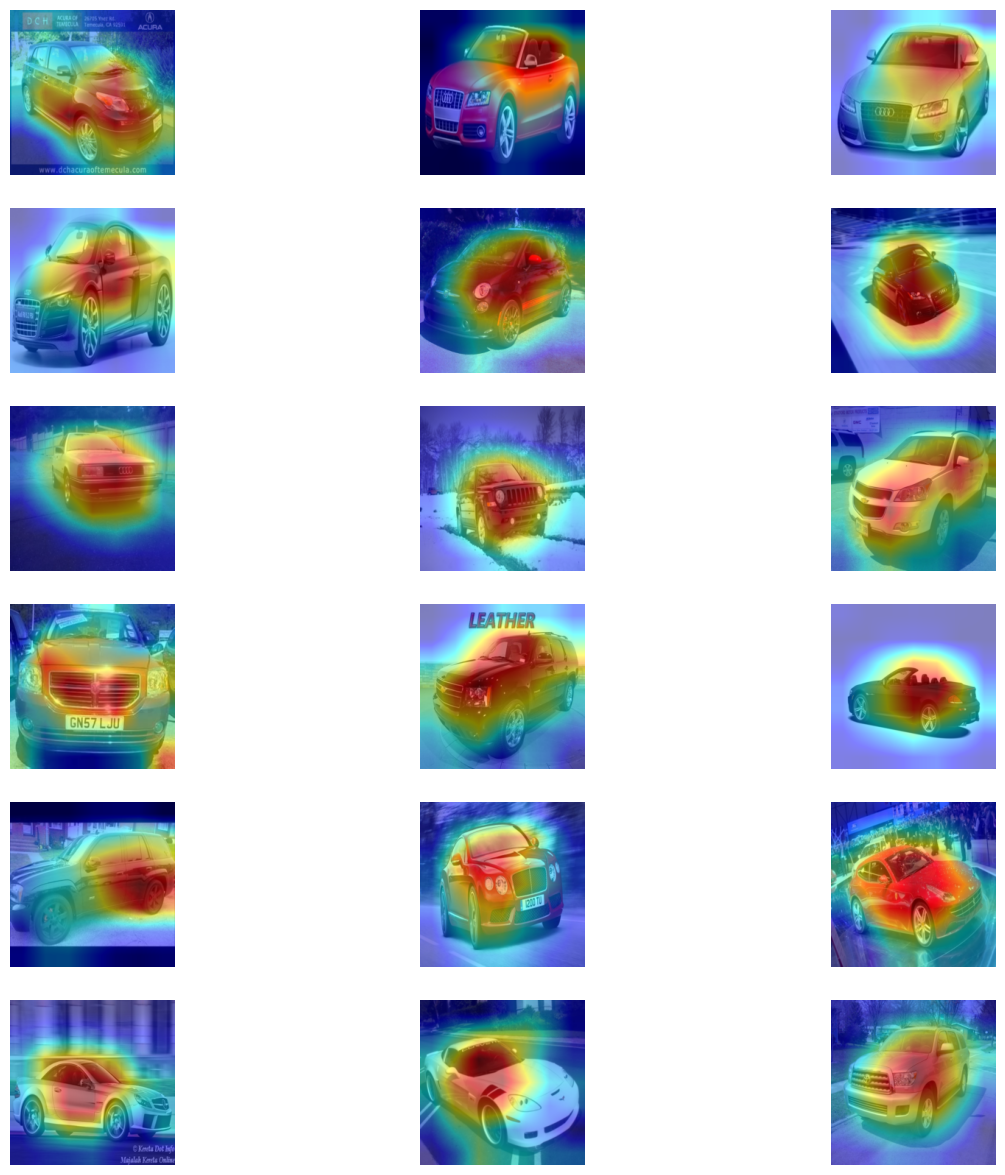

In [38]:
t = CarEmbedder(id_to_car, 3e-4, 512)
show_grad_cam(t.model, rand_items)